# Tôi tự học Keras

## Bài 10: Weighted average Ensemble Deep learning

### Bs. Lê Ngọc Khả Nhi

## Giới thiệu

Trong bài thứ 10 của series "Tôi tự học keras", Nhi sẽ hướng dẫn các bạn tạo ra một mô hình tập hợp mạng neuron sâu theo cơ chế trung bình/trọng số (Weighted averaging ensemble model), một cách thủ công.

Dữ liệu minh họa trong bài là một bài toán Multiclass-classification đơn giản với tabular data, được rút gọn từ một nghiên cứu có thực của nhóm tác giả Ayres de Campos. (Faculty of Medicine, University of Porto, Portugal) vào năm 2000 nhằm tạo ra một algorithm phân tích tự động xét nghiệm Tim thai(SisPorto 2.0). Bộ dữ liệu gồm 2126 hồ sơ tim thai đã qua xử lý(CTGs), được chia đều thành 2 phần train và test; mục tiêu nhằm phân loại 10 kiểu tim thai từ 15 features - đều là biến liên tục. 

Reference: Ayres de Campos et al. (2000) SisPorto 2.0 A Program for Automated Analysis of Cardiotocograms. J Matern Fetal Med 5:311-318

## Sơ chế dữ liệu

Dữ liệu đã được chuẩn bị sẵn trong thư mục hiện hành, gồm 2 tập train và test riêng biệt. Ta chỉ cần dùng pandas để tải và tạo ra 2 arrays cho features (X) và 2 arrays khác cho outcome (Y).

In [1]:
from pandas import read_csv

# Tải dữ liệu
train_df=read_csv("toco_train.csv").values
test_df=read_csv("toco_test.csv").values

# Tạo arrays
train_X = train_df[:,0:15].astype(float)
train_y = train_df[:,15]

test_X = test_df[:,0:15].astype(float)
test_y = test_df[:,15]

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa thang đo features và onehot encode 

scale_X = MinMaxScaler().fit(train_X)
sX_train = scale_X.transform(train_X)
sX_test = scale_X.transform(test_X)

enc = OneHotEncoder().fit(train_y.reshape(-1, 1))

Y_train = enc.transform(train_y.reshape(-1, 1)).toarray()
Y_test = enc.transform(test_y.reshape(-1, 1)).toarray()

Chúng ta bắt đầu bằng một mô hình Deep learning đơn giản như đã từng giới thiệu trong bài số 2, với 1 lớp hidden 64 neurons và 1 lớp Drop out. Mô hình được luyện trên train set và kiểm định trên testset.

In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.metrics import accuracy_score

from numpy import argmax
from numpy import array

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def history_plot(history = None):
    plt.figure(figsize=(10,5))
    plt.plot(hist.history['loss'],'b-',label='train')
    plt.plot(hist.history['val_loss'],'r--', label='test')
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(hist.history['acc'],'b-', label='train')
    plt.plot(hist.history['val_acc'],'r--', label='test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

## Dựng một phiên bản mô hình

In [5]:
n_features,n_labels = sX_train.shape[1], Y_train.shape[1]

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5, 
                           verbose=0)
model = Sequential()
model.add(Dense(64, input_dim = n_features, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_labels,activation='softmax'))
model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
model.summary()

hist=model.fit(sX_train, Y_train,
          validation_data=(sX_test, Y_test),
          epochs=300,
          verbose=0,
          batch_size=128,
          callbacks=[early_stop])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 1,674
Trainable params: 1,674
Non-trainable params: 0
_________________________________________________________________


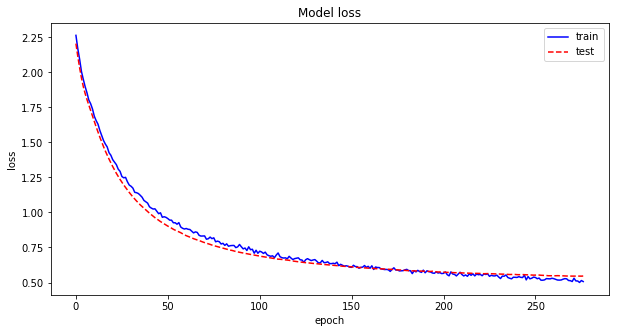

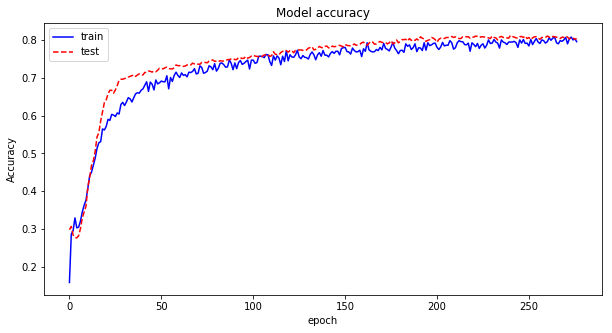

In [6]:
history_plot(hist)

In [7]:
def plot_confusion_matrix(cm,classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.coolwarm):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Truth')
    plt.xlabel('Predicted')

Kappa coef: 0.764
Normalized confusion matrix
[[0.86 0.01 0.01 0.   0.07 0.   0.01 0.04 0.   0.  ]
 [0.03 0.7  0.   0.   0.   0.   0.   0.28 0.   0.  ]
 [0.   0.   0.79 0.02 0.01 0.   0.   0.09 0.02 0.07]
 [0.   0.   0.65 0.23 0.   0.   0.   0.12 0.   0.  ]
 [0.06 0.   0.02 0.   0.88 0.   0.04 0.   0.   0.  ]
 [0.   0.   0.03 0.   0.   0.62 0.03 0.   0.   0.32]
 [0.02 0.   0.   0.   0.09 0.   0.89 0.   0.   0.  ]
 [0.01 0.02 0.02 0.   0.   0.   0.   0.93 0.01 0.  ]
 [0.   0.   0.33 0.   0.   0.03 0.   0.08 0.31 0.25]
 [0.   0.   0.26 0.   0.   0.07 0.   0.01 0.02 0.64]]


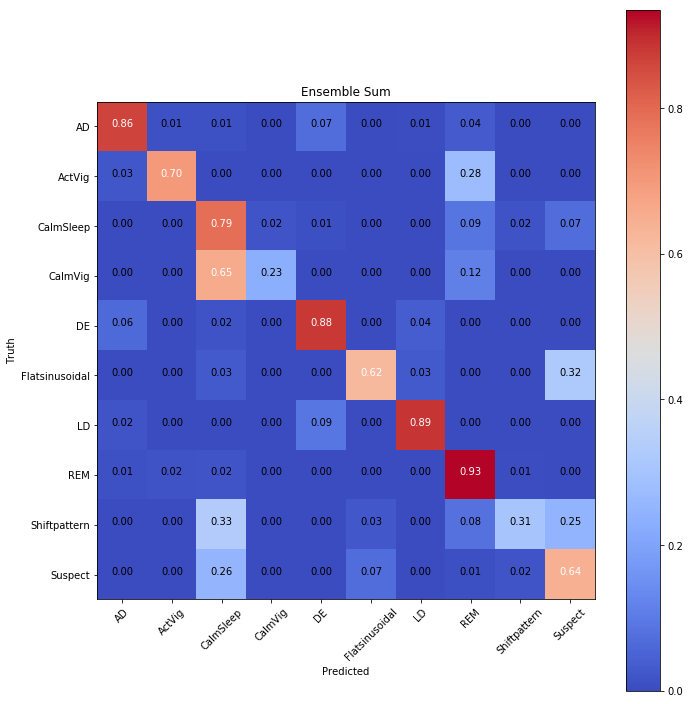

In [12]:
import itertools
from sklearn.metrics import confusion_matrix

yhat = model.predict_classes(sX_test)
cnf_matrix = confusion_matrix(argmax(Y_test, axis=1),yhat)

print('Kappa coef: %.3f' % kappa(argmax(Y_test, axis=1),yhat))

class_names = ['AD', 'ActVig', 'CalmSleep', 'CalmVig', 'DE','Flatsinusoidal', 'LD', 'REM', 'Shiftpattern','Suspect']

np.set_printoptions(precision=2)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, 
                      classes=class_names, 
                      normalize=True,
                      title='Ensemble Sum')

plt.show()

## Dựng 1 tập hợp 20 phiên bản mô hình

Kết quả kiểm định của mô hình mà ta vừa tạo ra trên tập testset là khá tốt, với Cohen's Kappa coef = 0.764. Tuy nhiên, việc huấn luyện mô hình Deep learning có tính ngẫu nhiên, điều này tạo ra một variance cho mỗi phiên bản mô hình, ngay cả trạng thái tối ưu của một phiên bản bất kì. 

Trong thí nghiệm sau đây, ta sẽ chứng tỏ rằng mỗi lần huấn luyện sẽ cho ra một phiên bản mô hình có phẩm chất không giống nhau:

Trước hết, chúng ta cần 1 hàm để làm công việc: dựng cấu trúc, huấn luyện rồi xuất mô hình cho cùng dữ liệu train set, yếu tố ngẫu nhiên trong quy trình này nằm ở bước chọn batch dữ liệu và early stopping. Khi áp dụng hàm này lặp lại n lần, ta sẽ tạo ra 1 tập hợp gồm n mô hình deep learning khác nhau.

In [14]:
# Hàm dựng 1 phiên bản mô hình (1 thành viên) cho cùng dữ liệu trainset
def fit_model(sX_train, Y_train, sX_test, Y_test):
    early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5, 
                           verbose=0)
    model = Sequential()
    model.add(Dense(64, input_dim = n_features, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_labels,activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    model.fit(sX_train, Y_train,
                     validation_data=(sX_test, Y_test),
                     epochs=300,
                     verbose=0,
                     batch_size=256,
                     callbacks=[early_stop])
    return model

Tiếp theo, ta cần 1 hàm khác, cho phép sử dụng 1 hay đồng thời nhiều phiên bản mô hình để thực hiện prediction (kết quả là 1 score), trong trường hợp tập hợp nhiều phiên bản mô hình, predicted score sẽ là tổng score của các thành viên trong tập hợp.

In [11]:
def ensemble_predictions(members, sX_test):
    yhats = [model.predict(sX_test) for model in members]
    yhats = array(yhats)
    # nếu có nhiều phiên bản, lấy tổng số các score
    summed = np.sum(yhats, axis=0)
    # chuyển score thành class bằng hàm argmax
    result = argmax(summed, axis=1)
    return result

Hàm thứ ba, cho phép tính kappa coefficient cho từng phiên bản mô hình trong một tập hợp. (Ghi chú: Cho bài toán binary classification, bạn có thể dùng Accuracy hay F1 score thay cho kappa), ý nghĩa của việc này nhằm kiểm tra phẩm chất các phiên bản mô hình.

In [13]:
def evaluate_n_members(members, n_members, sX_test, Y_test):
    subset = members[:n_members]
    print(len(subset))
    yhat = ensemble_predictions(subset,sX_test)
    return kappa(argmax(Y_test, axis=1), yhat)

In [15]:
# Bắt đầu thí nghiệm: tạo ra tập hợp 20 phiên bản mô hình
n_members = 20

members = [fit_model(sX_train, Y_train, 
                     sX_test, Y_test) for _ in range(n_members)]

In [16]:
# Đánh giá phẩm chất từng phiên bản trong tập hợp 20 mô hình
scores = list()
for i in range(1, n_members+1):
    score = evaluate_n_members(members, i,
                               sX_test, Y_test)
    print('Kappa = %.5f' % score)
    scores.append(score)

1
Kappa = 0.74204
2
Kappa = 0.75002
3
Kappa = 0.75217
4
Kappa = 0.75001
5
Kappa = 0.74772
6
Kappa = 0.75009
7
Kappa = 0.75017
8
Kappa = 0.75131
9
Kappa = 0.75134
10
Kappa = 0.75249
11
Kappa = 0.75482
12
Kappa = 0.75586
13
Kappa = 0.75700
14
Kappa = 0.75482
15
Kappa = 0.75598
16
Kappa = 0.75365
17
Kappa = 0.75358
18
Kappa = 0.75247
19
Kappa = 0.75481
20
Kappa = 0.75473


In [18]:
from numpy import median, mean
from numpy import std

print('Median Kappa: %.5f | Mean Kappa %.5f | SD Kappa: %.5f' % (median(scores), mean(scores), std(scores)))

Median Kappa: 0.75248 | Mean Kappa 0.75225 | SD Kappa: 0.00335


Kết quả thí nghiệm với tập hợp 20 mô hình cho thấy ngay cả ở trạng thái tối ưu, các mô hình này có Kappa coef khác nhau, dao động quanh giá trị trung tâm là 0.752 và với SD = 0.00335. Có một số mô hình kém chính xác hơn (Kappa = 0.74 so với 0.75).

Bây giờ, nếu ta sử dụng đồng loạt 20 phiên bản mô hình nói trên, ta sẽ có một kết quả classification với kappa = 0.755, kết quả này cao hơn 1 chút so với giá trị kappa trung bình của 20 phiên bản hoạt động riêng lẻ.

Kappa coef: 0.755
Normalized confusion matrix
[[0.86 0.   0.01 0.   0.09 0.   0.01 0.04 0.   0.  ]
 [0.03 0.6  0.   0.   0.   0.   0.   0.38 0.   0.  ]
 [0.   0.   0.8  0.01 0.01 0.   0.   0.09 0.01 0.08]
 [0.   0.   0.65 0.23 0.   0.   0.   0.12 0.   0.  ]
 [0.06 0.   0.02 0.   0.87 0.   0.06 0.   0.   0.  ]
 [0.   0.   0.03 0.   0.   0.38 0.03 0.   0.   0.56]
 [0.   0.   0.   0.   0.13 0.   0.87 0.   0.   0.  ]
 [0.02 0.01 0.02 0.   0.   0.   0.   0.94 0.   0.  ]
 [0.   0.   0.39 0.   0.   0.   0.   0.19 0.17 0.25]
 [0.   0.   0.22 0.   0.   0.   0.   0.02 0.01 0.74]]


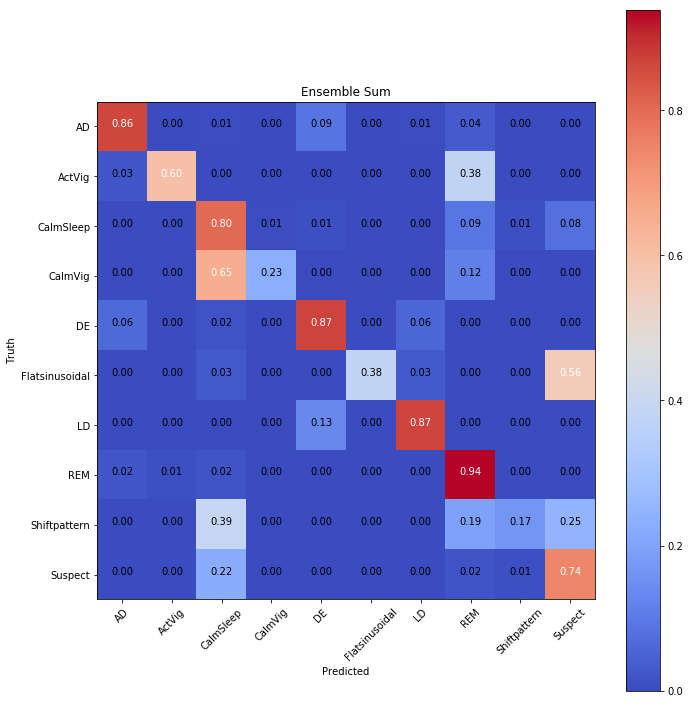

In [19]:
yhat = ensemble_predictions(members,sX_test)

print('Kappa coef: %.3f' % kappa(argmax(Y_test, axis=1),yhat))

cnf_matrix = confusion_matrix(argmax(Y_test, axis=1),yhat)

class_names = ['AD', 'ActVig', 'CalmSleep', 'CalmVig', 'DE','Flatsinusoidal', 'LD', 'REM', 'Shiftpattern','Suspect']

np.set_printoptions(precision=2)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, 
                      classes=class_names, 
                      normalize=True,
                      title='Ensemble Sum')

plt.show()

## Mô hình tập hợp sử dụng weighted averaging

Trên thực tế, ta không chỉ đơn giản tính tổng prediction score của nhiều phiên bản, nhưng mong đợi một tập hợp mô hình có cơ chế hoạt động tinh tế hơn. Một trong những phương pháp đơn giản được dùng là gán cho mỗi prediction score từ mỗi mô hình một trọng số khác nhau, và tính prediction score trung bình, với mục tiêu giảm tối thiểu sai sót.

Ta sẽ tiến hành làm ra một tập hợp như vậy, đầu tiên, Nhi viết lại hàm để thực hiện prediction có sử dụng trọng số:

In [20]:
from numpy import tensordot
from numpy.linalg import norm
from scipy.optimize import differential_evolution

def ensemble_predictions(members, weights, sX_test):
    yhats = [model.predict(sX_test) for model in members]
    yhats = array(yhats)
    summed = tensordot(yhats, weights, axes=((0),(0)))
    result = argmax(summed, axis=1)
    return result

Tương tự, hàm kiểm định phẩm chất của mô hình tập hợp, tiêu chí là Kappa

In [22]:
def evaluate_ensemble(members, weights, sX_test, Y_test):
	yhat = ensemble_predictions(members, weights, sX_test)
	return kappa(argmax(Y_test, axis=1), yhat)

Một hàm để chuẩn hóa giá trị trọng số :

In [23]:
def normalize(weights):
	result = norm(weights, 1)
	if result == 0.0:
		return weights
	return weights / result

Ta cần 1 hàm loss để tối ưu hóa cho trọng số trong tập hợp để tăng kappa lên tối ưu, càng gần 1 càng tốt: Đây là bước quan trọng để huấn luyện cho tập hợp mô hình

In [24]:
def loss_function(weights, members, sX_test, Y_test):
	normalized = normalize(weights)
	return 1.0 - evaluate_ensemble(members, normalized, sX_test, Y_test)

Ta kiểm tra lại lần nữa Accuracy của 20 phiên bản trong tập hợp:

In [25]:
for i in range(n_members):
	_, test_acc = members[i].evaluate(sX_test, Y_test, verbose=0)
	print('Model %d: %.3f' % (i+1, test_acc))

Model 1: 0.787
Model 2: 0.794
Model 3: 0.787
Model 4: 0.789
Model 5: 0.784
Model 6: 0.794
Model 7: 0.798
Model 8: 0.792
Model 9: 0.788
Model 10: 0.796
Model 11: 0.801
Model 12: 0.791
Model 13: 0.802
Model 14: 0.795
Model 15: 0.789
Model 16: 0.787
Model 17: 0.797
Model 18: 0.784
Model 19: 0.794
Model 20: 0.793


Nếu đặt trọng số như nhau = 1/20 cho mỗi phiên bản mô hình thì sao ? Ta sẽ thấy lại kết quả của cách làm tổng prediction score như trên, kappa = 0.755

In [26]:
# Trọng số bằng nhau, trạng thái cơ bản chưa qua tinh chỉnh
weights = [1.0/n_members for _ in range(n_members)]
score = evaluate_ensemble(members, weights, sX_test, Y_test)
print('Baseline Kappa: %.3f' % score)

Baseline Kappa: 0.755


Ta bắt đầu áp dụng hàm loss để tìm ra tổ hợp trọng số tối ưu nhằm đạt Kappa cao nhất:

In [27]:
# Đặt giới hạn cho weight
bound_w = [(0.0, 1.0)  for _ in range(n_members)]
# Huấn luyện tập hợp mô hình với hàm loss nhằm tối ưu hóa kappa
search_arg = (members, sX_test, Y_test)
result = differential_evolution(loss_function, bound_w, search_arg, maxiter=100, tol=0.01)
weights = normalize(result['x'])
print('Optimized Weights: %s' % weights)
# Kiểm tra lại phẩm chất của tập hợp sau huấn luyện
score = evaluate_ensemble(members, weights, sX_test, Y_test)
print('Optimized Kappa: %.3f' % score)

Optimized Weights: [0.07 0.01 0.08 0.01 0.01 0.07 0.07 0.01 0.02 0.08 0.08 0.06 0.08 0.09
 0.07 0.03 0.04 0.03 0.02 0.04]
Optimized Kappa: 0.762


Kết quả cho thấy khi sử dụng tập hợp 20 mô hình với trọng số tối ưu, ta có kết quả tốt hơn so với từng mô hình riêng lẻ, bao gồm Accuracy = 0.803 và Kappa = 0.762:

Optimized Kappa coef: 0.762
Optimized Accuracy: 0.803
Normalized confusion matrix
[[0.86 0.   0.01 0.   0.09 0.   0.01 0.04 0.   0.  ]
 [0.03 0.62 0.   0.   0.   0.   0.   0.35 0.   0.  ]
 [0.   0.   0.81 0.01 0.01 0.   0.   0.09 0.01 0.08]
 [0.   0.   0.65 0.23 0.   0.   0.   0.12 0.   0.  ]
 [0.06 0.   0.02 0.   0.88 0.   0.04 0.   0.   0.  ]
 [0.   0.   0.03 0.   0.   0.41 0.03 0.   0.   0.53]
 [0.   0.   0.   0.   0.13 0.   0.87 0.   0.   0.  ]
 [0.02 0.01 0.02 0.   0.   0.   0.   0.94 0.   0.  ]
 [0.   0.   0.39 0.   0.   0.   0.   0.19 0.17 0.25]
 [0.   0.   0.22 0.   0.   0.   0.   0.02 0.01 0.74]]


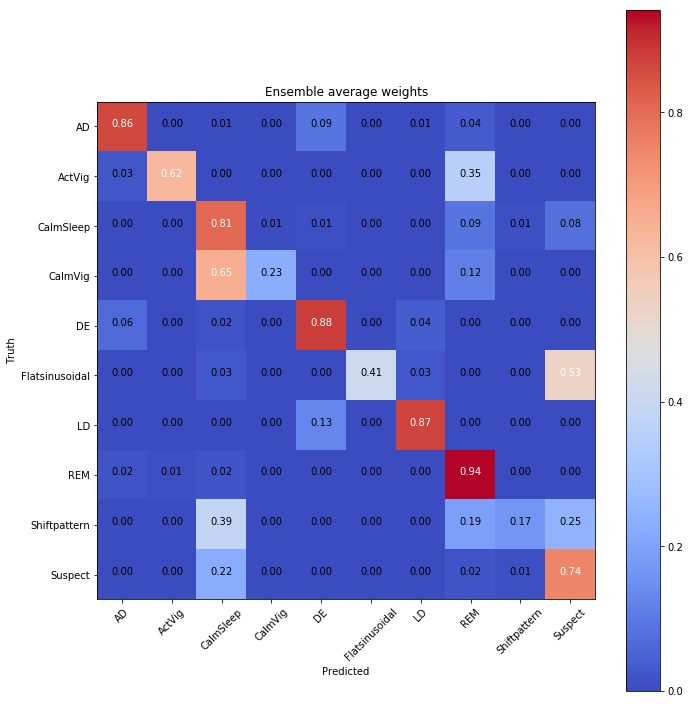

In [28]:
yhat = ensemble_predictions(members,weights,sX_test)

print('Optimized Kappa coef: %.3f' % kappa(argmax(Y_test, axis=1),yhat))
print('Optimized Accuracy: %.3f' % accuracy_score(argmax(Y_test, axis=1),yhat))

cnf_matrix = confusion_matrix(argmax(Y_test, axis=1),yhat)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, 
                      classes=class_names, 
                      normalize=True,
                      title='Ensemble average weights')

plt.show()

## Kết luận

Bài thực hành đến đây là hết. Tuy còn thủ công và rời rạc, thí nghiệm trong bài giúp bạn dựng được một mô hình Deep learning tập hợp gồm nhiều phiên bản mô hình, hoạt động hiệp đồng theo cơ chế trung bình với trọng số. Trong những bài tiếp theo, chúng ta sẽ lần lượt thử nghiệm những cơ chế khác của tập hợp mô hình.

Chúc các bạn thành công